# Survivorship bias

In [`CensoredSurvivalData.ipynb`](https://github.com/zuzannna/can-you-survive-this/blob/master/example_notebooks/CensoredSurvivalData.ipynb), we discussed what happens when you ignore censored observations: you introduce a bias. Depending on whether you have right or left censoring, this bias will be negative or positive, respectively  **(explain with picture?)**

Now let us consider the opposite situation: for example in finance, when analyzing the performance of companies, it can seem convenient to only consider companies that still exist today. However, this introduces another type of bias: survivorship bias. This can for instance lead us to draw incorrect conclusions about what leads to success.



In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

from lifelines import KaplanMeierFitter

## Risk-taking or not? (gambler's ruin)

Let us illustrate this with an exaggerated example. There are 100 companies that make money by two means: a stable yearly profit that is the same for everyone, and gambling. For the gambling part, they can choose a game with huge payoff if you win but low probability of winning, or a game with small payoffs if you win but high probability of winning. These businesses are assumed to always make a small profit, but their high or low risk decisions will in the long term determine their success.

The mathematical model of the financial success of these businesses is therefore a random walk along the positive axis, indicating the money they have in the bank. This random walk is governed by the probability of the gambling strategy that they have chosen, and it has a positive drift term, since we assume the businesses will generally make some money through risk-free activities. The starting point of the random walk is their starting capital, and as soon as any random walk reaches 0, the company has gone bankrupt and ceases to exist.



In [4]:
def random_walk(starting_capital, yearly_profit, high_risk, max_years=100):
    yearly_capital_amounts = [starting_capital]
    
    current_capital = starting_capital
    
    for i in range(max_years):
        if high_risk:
            gambling_outcome = np.random.choice((-50, 50), p=(.5, .5))
        else:
            gambling_outcome = np.random.choice((-10, 10), p=(.5, .5))
        
        current_capital += yearly_profit + gambling_outcome
        
        yearly_capital_amounts.append(max(0, current_capital))
        
        if current_capital <= 0:
            return yearly_capital_amounts
        
    return yearly_capital_amounts

In [5]:
starting_capital = 100
yearly_profit = 10

In [6]:
high_risk_companies = pd.DataFrame(
    [pd.Series(random_walk(starting_capital, yearly_profit, True, max_years=100)).rename(
        "high_risk_%d" %i) for i in range(50)]).T
low_risk_companies = pd.DataFrame(
    [pd.Series(random_walk(starting_capital, yearly_profit, False, max_years=100)).rename(
        "low_risk_%d" %i) for i in range(50)]).T

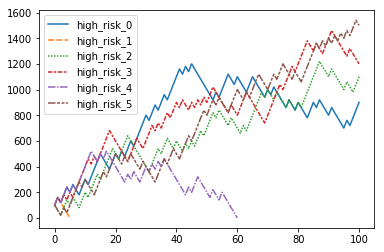

In [7]:
sns.lineplot(data=high_risk_companies[['high_risk_%d' %i for i in range(6)]]);

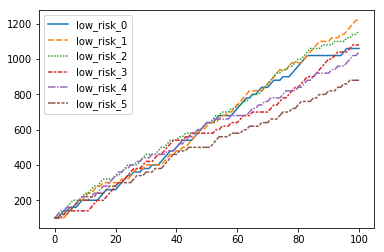

In [8]:
sns.lineplot(data=low_risk_companies[['low_risk_%d' %i for i in range(6)]]);

When analyzing the success of companies, we can look at a snapshot in time. What we will show is that there are several incorrect ways to analyze the success of these companies:
If you analyze a time snapshot too soon after the random walks have started, you may incorrectly conclude that the high risk strategies are best, since they will have earned more on average, but may not have had sufficient time to go bankrupt.
If you analyze a later snapshot, but only include all the companies that are still in existence at that point in time, you will again think high risk strategies are better,  since you will have excluded all the failed companies, and the high risk companies that are still in the running will likely have had huge payouts.

The correct way to deal with this situation is of course survival analysis.
